In [95]:
from skimage.color          import rgb2gray
from skimage.segmentation   import morphological_geodesic_active_contour, \
                                 inverse_gaussian_gradient

out_dir         = '/hdd/data/medical_image/bp_us/nsr_ac/ac_annotations/ac_vids/'

In [18]:
def get_boxes_for_frame(frame_num, vid_annotations):
    try:
        frame_annotations = vid_annotations[str(frame_num)]
        tracker = frame_annotations['tracker']
        bounding_boxes = frame_annotations['bounding_boxes']

        return tracker, bounding_boxes
    except:
        return None, None

In [64]:
def store_evolution_in(lst):
    """Returns a callback function to store the 
    evolution of the level sets in the given list."""

    def _store(x):
        lst.append(np.copy(x))

    return _store

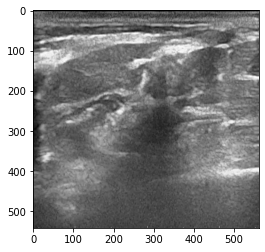

In [68]:
video_path = '/hdd/data/medical_image/bp_us/nsr_data/us_videos/9186.mp4'
vs = cv2.VideoCapture(video_path)

video_name   = os.path.basename(vid_path).split('.')[0]
vid_annotations = all_annotations[video_name] 
tracker_used, bounding_boxes = get_boxes_for_frame(current_frame_num, vid_annotations) 

gray_frame = rgb2gray(frame)
init_ls    = np.zeros(gray_frame.shape, dtype=np.int8) 
if tracker_used is not None:       
    bounding_boxes = eval(bounding_boxes)                 
    if (bounding_boxes is not None) and (len(bounding_boxes) > 0): 
        for box in bounding_boxes: 
            (x, y, w, h) = [int(v) for v in box]
            init_ls[y:y+h, x:x+w] = 1 

while vs.isOpened():
    ret, frame = vs.read()
    if ret==True:
        current_frame_num = int(vs.get(cv2.CAP_PROP_POS_FRAMES))-1
        if current_frame_num == 6:
            break

plt.imshow(gray_frame, cmap='gray')            

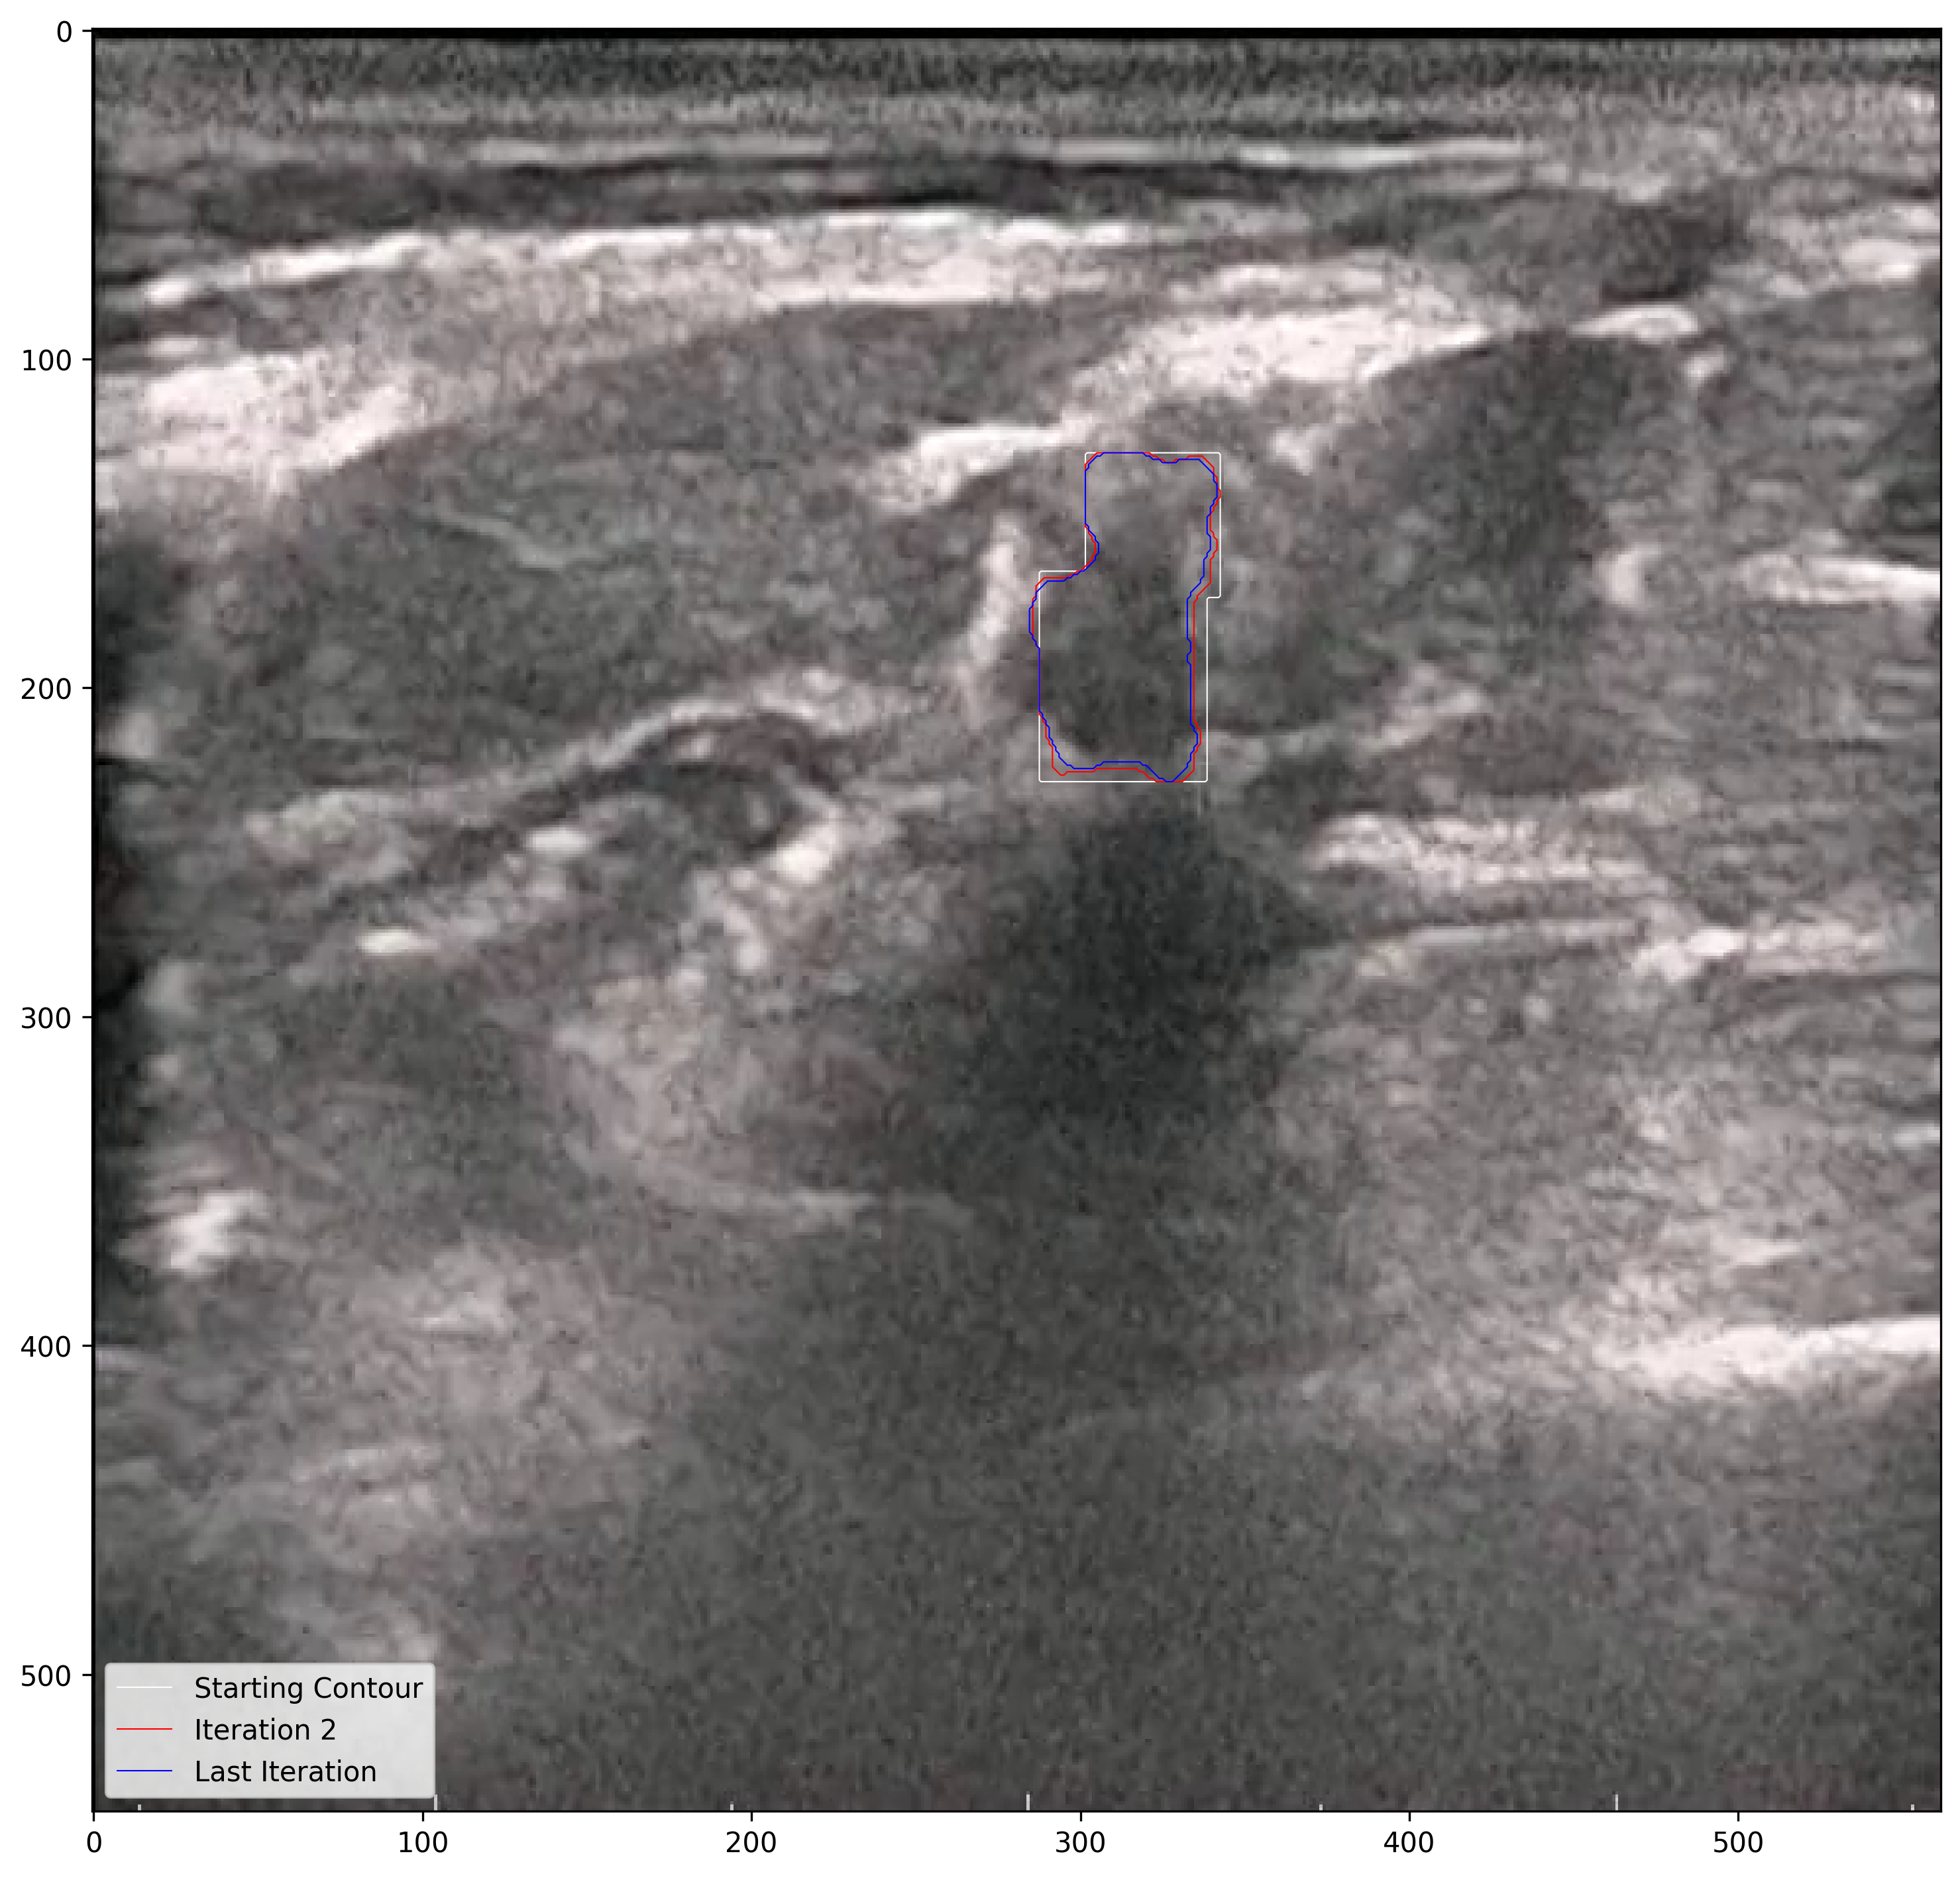

In [92]:
gimage = inverse_gaussian_gradient(gray_frame)
evolution = []
callback = store_evolution_in(evolution)
ls     = morphological_geodesic_active_contour(gimage, 
                                            iterations     = 3, 
                                            init_level_set = init_ls, 
                                            smoothing      = 4, 
                                            balloon        = -1,
                                            threshold      = 0.7,
                                            iter_callback  = callback )
plt.figure(figsize=(12,12), dpi=300)
plt.imshow(frame) 
contour = plt.contour(evolution[0], [0.5], linewidths = 0.5, colors='w') 
contour.collections[0].set_label("Starting Contour") 
contour = plt.contour(evolution[2], [0.5], linewidths = 0.5, colors='r')
contour.collections[0].set_label("Iteration 2")
contour = plt.contour(evolution[-1], [0.5], linewidths = 0.5, colors='b')
contour.collections[0].set_label("Last Iteration")
plt.legend(loc="lower left")
plt.show()

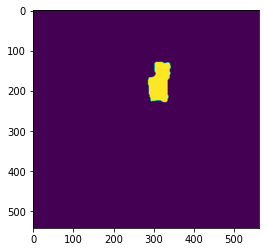

In [93]:
plt.imshow(evolution[2])

In [135]:
fourcc = cv2.VideoWriter_fourcc(*'XVID')
FPS = 4
fps = FPS
def process_video(video_path, out_dir, vid_annotations):
    try: vs = cv2.VideoCapture(video_path)   # Create Opencv video stream object
    except: pass

    if not vs.isOpened(): 
        print ("Error: Could not open video file at -->", video_path)
        exit() 

    video_name   = os.path.splitext(os.path.basename(video_path))[0] 
    vid_out_path = os.path.join(out_dir, video_name + '_ac' +'.avi') 
    #print('Generated ', vid_out_path)
    height = int(vs.get(cv2.CAP_PROP_FRAME_HEIGHT ))
    width  = int(vs.get(cv2.CAP_PROP_FRAME_WIDTH ))     
    spatial_resolution = (width , height) 
    out = cv2.VideoWriter( vid_out_path, fourcc, fps, spatial_resolution, isColor = True)        
        
    while vs.isOpened():
        ret, frame = vs.read()
        if ret==True:
            current_frame_num = int(vs.get(cv2.CAP_PROP_POS_FRAMES))-1
            base_primary      = os.path.splitext(os.path.basename(video_path))[0] 

            tracker_used, bounding_boxes = get_boxes_for_frame(current_frame_num, vid_annotations)

            gray_frame = rgb2gray(frame)
            init_ls    = np.zeros(gray_frame.shape, dtype=np.int8) 
            evolution = []
            callback = store_evolution_in(evolution)             

            if tracker_used is not None:       
                bounding_boxes = eval(bounding_boxes) 
                if (bounding_boxes is not None) and (len(bounding_boxes) > 0): 
                    for box in bounding_boxes: 
                        (x, y, w, h) = [int(v) for v in box]
                        init_ls[y:y+h, x:x+w] = 1 


                    gimage = inverse_gaussian_gradient(gray_frame)
                    ls     = morphological_geodesic_active_contour(gimage, 
                                                                iterations     = 9, 
                                                                init_level_set = init_ls, 
                                                                smoothing      = 4, 
                                                                balloon        = -1,
                                                                threshold      = 0.7,
                                                                iter_callback  = callback ) 
                    contour_0 = cv2.findContours(evolution[0].astype(np.uint8),cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)[-2] 
                    contour_3 = cv2.findContours(evolution[3].astype(np.uint8),cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)[-2] 
                    contour_6 = cv2.findContours(evolution[6].astype(np.uint8),cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)[-2] 
                    contour_L = cv2.findContours(evolution[-1].astype(np.uint8),cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)[-2] 

                    for contour in contour_0:  
                        cv2.drawContours(frame, contour, -1, (255,255,255), 1)  # White
                    for contour in contour_3:  
                        cv2.drawContours(frame, contour, -1, (255, 0,   0), 1) # Blue
                    for contour in contour_6:  
                        cv2.drawContours(frame, contour, -1, (0, 0,   255), 1) # Red
                    for contour in contour_L:  
                        cv2.drawContours(frame, contour, -1, (0,   255, 0), 1) # Green

                    text = "{}: {}".format('frame # ', current_frame_num)
                    cv2.putText(frame, text, (10, height - 40 ), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1) 
                    out.write(frame.astype('uint8'))
                else:
                    out.write(frame.astype('uint8'))  
            else:
                out.write(frame.astype('uint8')) 
                    
        else:
            vs.release()
            

In [128]:
vid_path = '/hdd/data/medical_image/bp_us/nsr_data/us_videos/9186.mp4'
video_name   = os.path.basename(vid_path).split('.')[0]
vid_annotations = all_annotations[video_name]
len(vid_annotations)

109

In [130]:
process_video(vid_path, out_dir, vid_annotations)

In [131]:
patient_data_csv_path = '/hdd/data/medical_image/bp_us/nsr_ac/patient_data.csv'
patient_info = pd.read_csv(patient_data_csv_path)
isc_vids = list(patient_info[patient_info.nerve == 'sc'].vid_name)
isc_vids
len(isc_vids) 

157

In [132]:
isc_paths = glob('/hdd/data/medical_image/bp_us/nsr_ac/us_videos'  + "/*.mp4")
isc_paths = [p for p in isc_paths if int(os.path.splitext(os.path.basename(p))[0]) in isc_vids]
len(isc_paths)

157

In [125]:
annotations_dir   = '/hdd/data/medical_image/bp_us/nsr_ac/bb_annotations'
annotations_paths = glob(os.path.join(annotations_dir, '**', '*.txt'), recursive=True)
print('# annotation txt files = ', len(annotations_paths))

all_annotations = defaultdict(dict)
for a_path in annotations_paths:
    vid_name = os.path.basename(a_path)[:-4]
    annotations={}
    input_file = open(a_path, 'r')
    for line in input_file:
        json_decode = json.loads(line)
        for item in json_decode:
            all_annotations[vid_name][item] = json_decode[item]
    input_file.close() 

# annotation txt files =  202


In [127]:
for vid_path in isc_paths:
    video_name   = os.path.basename(vid_path).split('.')[0]
    vid_annotations = all_annotations[video_name]
    process_video(vid_path, out_dir, vid_annotations)

  0%|          | 0/39 [00:00<?, ?it/s]

In [136]:
# Actually below is SC
for vid_path in isc_paths:
    video_name   = os.path.basename(vid_path).split('.')[0]
    vid_annotations = all_annotations[video_name]
    #process_video(vid_path, out_dir, vid_annotations)
    Process(target=process_video, args=(vid_path, out_dir, vid_annotations,)).start()

## Parallel GAC - Actual iterations

In [34]:
import os
import cv2
import csv
import json

import numpy as np
import pandas as pd

from tqdm.auto           import tqdm
from collections         import defaultdict
from glob                   import glob
from skimage.color          import rgb2gray
from skimage.segmentation   import morphological_geodesic_active_contour, \
                                 inverse_gaussian_gradient
from multiprocessing        import Process, Queue
from matplotlib          import pyplot as plt

vids_folder   = '/hdd/data/medical_image/bp_us/nsr_ac/eSaote/vids'
bb_annotations_folder = '/hdd/data/medical_image/bp_us/nsr_ac/eSaote/bb_annotations'
ac_out_folder = '/hdd/data/medical_image/bp_us/nsr_ac/eSaote/ac_annotations'
subjects_csv  = '/hdd/data/medical_image/bp_us/nsr_ac/eSaote/subjects_data.csv'

In [7]:
vids = os.listdir(vids_folder)
vids = [int(os.path.splitext(os.path.basename(v))[0]) for v in vids]
vids.sort()

subjects_info = pd.read_csv(subjects_csv)
csv_vids = list(subjects_info.vid_name)
csv_vids.sort()

vids == csv_vids

True

In [10]:
annotations_paths = glob(os.path.join(bb_annotations_folder, '**', '*.txt'), recursive=True)
print('# annotation txt files = ', len(annotations_paths))

bb_annotations = defaultdict(dict)
for a_path in annotations_paths:
    vid_name = os.path.basename(a_path)[:-4]
    annotations={}
    input_file = open(a_path, 'r')
    for line in input_file:
        json_decode = json.loads(line)
        for item in json_decode:
            bb_annotations[vid_name][item] = json_decode[item]
    input_file.close()

# annotation txt files =  202


In [15]:
bb_vids = [int(v) for v in list(bb_annotations.keys())]
bb_vids.sort()
vids == bb_vids
[v for v in vids if v not in bb_vids]

[4578, 8903]

In [ ]:
# Don't wprry. Both are empty i.e. negative vids

In [16]:
[v for v in bb_vids if v not in vids]

[]

In [17]:
len(bb_vids)

200

In [32]:
def generate_ac_masks(video_path, out_dir, num_iter, annotations):
    vs = cv2.VideoCapture(video_path)

    while vs.isOpened():
        ret, frame = vs.read()
        if ret==True:
            current_frame_num = int(vs.get(cv2.CAP_PROP_POS_FRAMES))-1
            base_primary      = os.path.splitext(os.path.basename(video_path))[0]
            out_path          = os.path.join(out_dir, base_primary + '_' + str(current_frame_num).zfill(3) + '.jpg')
            tracker_used, bounding_boxes = get_boxes_for_frame(current_frame_num, annotations)

            gray_frame = rgb2gray(frame)
            init_ls    = np.zeros(gray_frame.shape, dtype=np.int8) 

            if tracker_used is not None:       
                bounding_boxes = eval(bounding_boxes)                 
                if (bounding_boxes is not None) and (len(bounding_boxes) > 0): 
                    for box in bounding_boxes: 
                        (x, y, w, h) = [int(v) for v in box]
                        init_ls[y:y+h, x:x+w] = 1 

                    if int(num_iter) > 0:
                        gimage = inverse_gaussian_gradient(gray_frame)
                        ls     = morphological_geodesic_active_contour(gimage, 
                                                                    iterations     = int(num_iter), 
                                                                    init_level_set = init_ls, 
                                                                    smoothing      = 4, 
                                                                    balloon        = -1,
                                                                    threshold      = 0.7 )
                        plt.imsave(out_path, ls, cmap="gray")
                    else:
                        plt.imsave(out_path, init_ls, cmap="gray")
                else:
                    plt.imsave(out_path, init_ls, cmap="gray")
            else:
                plt.imsave(out_path, init_ls, cmap="gray")
        else:
            vs.release()

In [36]:
vid_paths = glob(vids_folder  + "/*.mp4")
for vid_p in tqdm(vid_paths):
    video_name = int(os.path.splitext(os.path.basename(vid_p))[0])
    gac_iter   = subjects_info.loc[subjects_info.vid_name == int(video_name),'gac_iter'].iloc[0]
    ac_dir     = os.path.join(ac_out_folder, str(video_name))
    os.makedirs(ac_dir, exist_ok=True)
    vid_annotations = bb_annotations[str(video_name)] 
    #generate_ac_masks(vid_p, ac_dir, gac_iter, vid_annotations)
    Process(target=generate_ac_masks, args=(vid_p, ac_dir, gac_iter, vid_annotations,)).start()
#print(video_name, gac_iter, ac_dir, len(vid_annotations))

  0%|          | 0/202 [00:00<?, ?it/s]